**Notebook authors:**
* Rebecca Conti 1896168
* Jacopo Orsini 2099929
* Antonella Mei 1887894
* Lorenzo Pannacci 1948926

**Work distribution:**
* Data cleaning: Rebecca
* Statistical features extraction: Jacopo
* TF-IDF features extraction: Antonella
* Per-Character features extraction: Lorenzo
* Decision tree models: Rebecca
* Logistic regression models: Jacopo
* k-NN models: Antonella
* Neural Networks models: Lorenzo

# Setup

In [1]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import csv
import math
import re

# feature extraction
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# performance analysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [2]:
filepath = r"data.csv"

# Data cleaning

---

While reading our dataset, we encountered some issues due to a mismatch in the number of columns, so we decided to output the row number and its content to determine our next steps, whether we needed to eliminate them or if we could retain them with some modifications.


---

In [3]:
with open(filepath, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    data = []
    for row in reader:
        if len(row) == 2:  # we expect 2 fields per line
            data.append(row)
        else:
            print(f"Issue with line {reader.line_num}: {row}")

Issue with line 2810: ['selim', 'selim_syl1905@hotmail.com', '88.230.79.161', 'Poftya123', '2']
Issue with line 4641: ['Selim', 'delioreanxs@hotmail.com', '85.97.14.203', 'selim123456', '2']
Issue with line 7171: ['Selim', 'mt2gurur@hotmail.com', '88.227.187.9', 'benerkin98', '2']
Issue with line 11220: ['Selim', 'facebookselim4@hotmail.com', '94.123.218.111', '4938863a', '2']
Issue with line 13809: ['selim', 'anakonda_252@hotmail.com', '85.110.117.124', '4560458sg', '2']
Issue with line 14132: ['selim', 'mamedov.kenan@mail.ru', '93.184.224.230', '1449a1449a', '2']
Issue with line 14293: ['Selim', 'destek@migmedya.com', '94.122.28.186', 'sanane05', '2']
Issue with line 14865: ['selim', 'elitebank44@gmail.com', '78.180.132.32', 'selim123', '2']
Issue with line 17419: ['selim', 'memleketim.info@gmail.com', '78.183.49.245', 'salih5134', '2']
Issue with line 22801: ['selim', 'canersastim@gmail.com', '78.160.123.7', 'tc1416', '2']
Issue with line 25001: ['selim', 'arifselim.ask@gmail.com', 

---

We utilized the `csv` library to process the dataset, eliminating superfluous columns. This was necessary as we observed that numerous rows included additional information such as name, email, and IP address, beyond the password and strength data we were interested in. We then created a new dataset, `cleaned_data`, into which we incorporated the accurate data. We also corrected the header, which was initially misread due to the varying number of columns in different rows. Specifically, while the first two columns had the headers we required, rows with more than two columns had different headers.

---

In [4]:
df = []

with open(filepath, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)

    for row in reader:
        if len(row) > 2:  
            last_two_columns = ','.join(row[-2:])  
            df.append(last_two_columns.split(','))  
        else:
            df.append(row)

df = pd.DataFrame(df, columns=['Password', 'Strength'])
df = df.dropna()
df = df.drop_duplicates()
df = df.drop(0).reset_index(drop=True)

df

,Password,Strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1
...,...,...
669836,10redtux10,1
669837,infrared1,1
669838,184520socram,1
669839,marken22a,1


---

There is a group of characters that do not belong to password as they are non-printable control characters. We decided to remove every password that contains a character of this group.

---

In [5]:
chars_to_remove = ['\x7f', '\x81', '\xa0', '\x01', '\x02', '\x04', '\x05', '\x06',
                   '\x08', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x16',
                   '\x17', '\x18', '\x19', '\x1b', '\x1c', '\x1d', '\x1e', '\x8d']

for c in chars_to_remove:
    df = df[~df['Password'].str.contains(c)]

df

,Password,Strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1
...,...,...
669836,10redtux10,1
669837,infrared1,1
669838,184520socram,1
669839,marken22a,1


---

We convert the dtype of the column Strenght from object to int64:

---

In [6]:
# convert 'Strength' column to numeric type (by default int64)
df['Strength'] = pd.to_numeric(df['Strength'], errors='coerce')  

# check the data types after conversion
df.dtypes

Password    object
Strength     int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669806 entries, 0 to 669840
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Password  669806 non-null  object
 1   Strength  669806 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [8]:
total_rows = len(df)
print(f"The total number of rows in the DataFrame is: {total_rows}")

The total number of rows in the DataFrame is: 669806


---

The total number of rows in the dataset coincides with the number of non-null values in our dataset, indicating that there are no null values, but we decide to do a double check:

---

In [9]:
null_passwords = df['Password'].isnull().sum()

if null_passwords > 0:
    print(f"the column 'Password' contain {null_passwords} null value.")
else:
    print("No null value in the 'Password' column.")

null_strength= df['Strength'].isnull().sum()
if null_strength > 0:
    print(f"the column 'Strength' contain {null_strength} null value.")
else:
    print("No null value in the 'Strebgth' column.")

No null value in the 'Password' column.
No null value in the 'Strebgth' column.


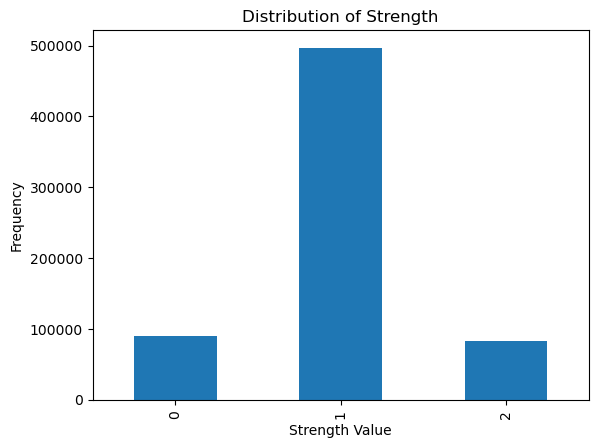

In [10]:
# histogram plot of the 'Strength' column
df['Strength'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Strength')
plt.xlabel('Strength Value')
plt.ylabel('Frequency')
plt.show()

---

Dataset seems very unbalanced towards the value "1", that means a password with "medium strength". From this unbalance we can use as a baseline the model that always answer "1" to any classification.

The performance of this baseline model is:

---

In [11]:
baseline = df[df["Strength"] == 1].shape[0] / df.shape[0]
print("The baseline accuracy for our models is:", baseline)

The baseline accuracy for our models is: 0.7416968495355372


# Features extraction

## Stat features

---

The statistical features represent the first group of features extracted from the initial dataset; in particular, we focused on gaining information from the password itself, collecting information about how the passorwd was structered and creating new features. Some examples of these new features are the percentage of letters inside the password, the lowercase frequency, the presence of date of birth or the presence of sequences of letters correspong to the 'querty' keyboard scheme.

---

In [12]:
df_stat = df.copy()

df_stat['Password'] = df_stat['Password'].replace({np.nan: ''})

# length
df_stat['length'] = df_stat['Password'].apply(lambda x: len(str(x)))

# number of letters
df_stat['num_letters'] = df_stat['Password'].apply(lambda x: sum(c.isalpha() for c in str(x)))

# percentage of letters
df_stat['percentage_letters'] = df_stat['Password'].apply(lambda x: round((sum(c.isalpha() for c in str(x)) / len(str(x))) * 100, 1) if len(str(x)) > 0 else 0)

# number of numbers
df_stat['num_numbers'] = df_stat['Password'].apply(lambda x: sum(c.isdigit() for c in str(x)))

# percentage of numbers
df_stat['percentage_numbers'] = df_stat['Password'].apply(lambda x: round((sum(c.isdigit() for c in str(x)) / len(str(x))) * 100, 1) if len(str(x)) > 0 else 0)

# special character
df_stat['has_special_characters'] = df_stat['Password'].apply(lambda x: any(not c.isalnum() for c in str(x)))

# uppercase count
def calculate_uppercase_count(password):
    return sum(1 for char in password if char.isupper())
df_stat['uppercase_count'] = df_stat['Password'].apply(calculate_uppercase_count)

# percentage uppercase
df_stat['percentage_uppercase'] = (df_stat['uppercase_count'] / df_stat['num_letters']) * 100
df_stat['percentage_uppercase'] = df_stat['percentage_uppercase'].round(1)
df_stat['percentage_uppercase'].fillna(0, inplace=True)

# lowercase count
def calculate_lowercase_count(password):
    return sum(1 for char in password if char.islower())
df_stat['lowercase_count'] = df_stat['Password'].apply(calculate_lowercase_count)

# percentage lowercase
df_stat['percentage_lowercase'] = (df_stat['lowercase_count']/df_stat['num_letters'])*100
df_stat['percentage_lowercase'] = df_stat['percentage_lowercase'].round(1)
df_stat['percentage_lowercase'].fillna(0, inplace=True)

In [13]:
# lowercase frequency
def lowercase_letter_frequency(password):
    if len(password) == 0:
        return 0
    lowercase_count = sum(1 for char in password if char.islower())
    lowercase_frequency = lowercase_count / len(password)
    return lowercase_frequency
df_stat['lowercase_frequency'] = df_stat['Password'].apply(lowercase_letter_frequency)

# uppercase frequency
def uppercase_letter_frequency(password):
    if len(password) == 0:
        return 0
    uppercase_count = sum(1 for char in password if char.isupper())
    uppercase_frequency = uppercase_count / len(password)
    return uppercase_frequency
df_stat['uppercase_frequency'] = df_stat['Password'].apply(uppercase_letter_frequency)

# numbers frequency
def numbers_frequency(password):
    if len(password) == 0:
        return 0
    numbers_count = sum(1 for char in password if char.isdigit())
    numbers_frequency = numbers_count / len(password)
    return numbers_frequency
df_stat['numbers_frequency'] = df_stat['Password'].apply(numbers_frequency)

# unique characters, if that pasword has charaters that are repeated
def calculate_unique_char_presence(password):
    return len(set(password)) == len(password)
df_stat['unique_char_presence'] = df_stat['Password'].apply(calculate_unique_char_presence)

# entropy, link of the website where we found this measure:
# https://gabrieleromanato.name/python-how-to-evaluate-password-entropy
def calculate_entropy(password):
    character_set = set(password)
    character_set_size = len(character_set)
    password_size = len(password)
    entropy = math.log2(character_set_size ** password_size)
    return entropy
df_stat['entropy'] = df_stat['Password'].apply(calculate_entropy)

# has consecutve uppercase letters
def has_consecutive_uppercase(password):
    pattern = re.compile(r'[A-Z]{2,}')  
    return bool(pattern.search(password))
df_stat['consecutive_uppercase_letters'] = df_stat['Password'].apply(has_consecutive_uppercase)

# has consecutive lowercase letters
def has_consecutive_lowercase(password):
    pattern = re.compile(r'[a-z]{2,}')  
    return bool(pattern.search(password))
df_stat['consecutive_lowercase_letters'] = df_stat['Password'].apply(has_consecutive_lowercase)

# has consecutive numbers
def has_consecutive_number(password):
    pattern = re.compile(r'[0-9]{2,}')  
    return bool(pattern.search(password))
df_stat['consecutive_numbers'] = df_stat['Password'].apply(has_consecutive_number)

# has keyboard patterns
def has_keyboard_pattern(password):
    keyboard_patterns = ["qwertyuiop", "asdfghjkl", "zxcvbnm", "1234567890"]
    for pattern in keyboard_patterns:
        if pattern in password.lower():
            return True
    return False
df_stat['querty_sequence'] = df_stat['Password'].apply(has_keyboard_pattern) #there are 293 rows with that

In [14]:
# common words
common_words = [
    'the', 'be', 'to', 'of', 'and', 'in', 'that', 'have', 'for', 'not', 'with', 'as', 'you', 'do',
    'this', 'but', 'his', 'by', 'from', 'they', 'we', 'say', 'her', 'she',
    'or', 'an', 'will', 'my', 'one', 'all', 'would', 'there', 'their', 'what',
    'so', 'up', 'out', 'if', 'about', 'who', 'get', 'which', 'go', 'me',
    'when', 'make', 'can', 'like', 'time', 'just', 'him', 'know', 'take',
    'people', 'into', 'year', 'your', 'good', 'some', 'could', 'them', 'see', 'other',
    'than', 'then', 'now', 'look', 'only', 'come', 'its', 'over', 'think', 'also',
    'back', 'after', 'use', 'two', 'how', 'our', 'work', 'first', 'well', 'way',
    'even', 'new', 'want', 'because', 'any', 'these', 'give', 'day', 'most', 'us'
]

def contains_common_word(password):
    password_lower = password.lower()
    for word in common_words:
        if word in password_lower:
            return True
    return False
df_stat['common_word'] = df_stat['Password'].apply(contains_common_word)

def contains_birthday_year(password):
    pattern = re.compile(r'(0[1-9]|[1-2][0-9]|3[0-1])(0[1-9]|1[0-2])(19[4-9][0-9]|20[0-1][0-9]|2023)')
    return bool(pattern.search(password))
df_stat['year_birth'] = df_stat['Password'].apply(contains_birthday_year)

df_stat

,Password,Strength,length,num_letters,percentage_letters,num_numbers,percentage_numbers,has_special_characters,uppercase_count,percentage_uppercase,...,uppercase_frequency,numbers_frequency,unique_char_presence,entropy,consecutive_uppercase_letters,consecutive_lowercase_letters,consecutive_numbers,querty_sequence,common_word,year_birth
0,kzde5577,1,8,4,50.0,4,50.0,False,0,0.0,...,0.0,0.500000,False,20.679700,False,True,True,False,False,False
1,kino3434,1,8,4,50.0,4,50.0,False,0,0.0,...,0.0,0.500000,False,20.679700,False,True,True,False,True,False
2,visi7k1yr,1,9,7,77.8,2,22.2,False,0,0.0,...,0.0,0.222222,False,27.000000,False,True,False,False,False,False
3,megzy123,1,8,5,62.5,3,37.5,False,0,0.0,...,0.0,0.375000,True,24.000000,False,True,True,False,True,False
4,lamborghin1,1,11,10,90.9,1,9.1,False,0,0.0,...,0.0,0.090909,True,38.053748,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669836,10redtux10,1,10,6,60.0,4,40.0,False,0,0.0,...,0.0,0.400000,False,30.000000,False,True,True,False,False,False
669837,infrared1,1,9,8,88.9,1,11.1,False,0,0.0,...,0.0,0.111111,False,27.000000,False,True,False,False,True,False
669838,184520socram,1,12,6,50.0,6,50.0,False,0,0.0,...,0.0,0.500000,True,43.019550,False,True,True,False,True,False
669839,marken22a,1,9,7,77.8,2,22.2,False,0,0.0,...,0.0,0.222222,False,25.266194,False,True,True,False,False,False


---

Let's check the correlation between the extracted features and the target value:

---

In [15]:
df_stat.drop(['Password'], axis=1).corr()["Strength"].sort_values(ascending = False)

Strength                         1.000000
length                           0.838639
entropy                          0.820633
num_letters                      0.626136
uppercase_count                  0.620071
consecutive_uppercase_letters    0.587224
uppercase_frequency              0.568979
percentage_uppercase             0.521380
lowercase_count                  0.226105
has_special_characters           0.179220
num_numbers                      0.175597
percentage_letters               0.079043
common_word                      0.032396
year_birth                       0.017083
querty_sequence                  0.004886
consecutive_numbers             -0.020600
consecutive_lowercase_letters   -0.080613
numbers_frequency               -0.092120
percentage_numbers              -0.092276
unique_char_presence            -0.205980
lowercase_frequency             -0.324765
percentage_lowercase            -0.498886
Name: Strength, dtype: float64

---

We see a very high correlation between strength and features that contains informations about the password length.

---

## TF-IDF features

---

Our goal is to check wether character-level analysis on frequency provides valuable insights, computing the TF-IDF score for each character of the passwords.\
It is computed by multiplying its Term Frequency within the password, by the Inverse Document Frenquecy. This will be used to identify characters that are both frequently occurring within a specific password and relatively rare across the entire dataset; leading us to the measure of uniqueness or importance of those characters within that password.

---

In [16]:
# TF-IDF of each sample's character
psw = df['Password'].values
vec = TfidfVectorizer(analyzer='char')
X = vec.fit_transform(psw)
tfidf_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out(), index=df.index)

# merge the original DataFrame with the TF-IDF DataFrame based on indices
tfidf_features = df[["Password", "Strength"]].join(tfidf_df)
tfidf_features

,Password,Strength,,!,"""",#,$,%,&,(,...,ÿ,œ,ƒ,—,‚,‡,…,‹,›,™
0,kzde5577,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,kino3434,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,visi7k1yr,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,megzy123,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,lamborghin1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669836,10redtux10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669837,infrared1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669838,184520socram,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669839,marken22a,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

We want to check if our dataset contains some unexpected character column:

---

In [17]:
all_columns = tfidf_features.columns.to_list()
print(all_columns)

['Password', 'Strength', ' ', '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¨', '«', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¹', 'º', '¼', '½', '¾', '¿', '×', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'œ', 'ƒ', '—', '‚', '‡', '…', '‹', '›', '™']


## Per-Character Features

---

First of all we decided to cap the password string length to 30 as only a few outliers surpass this length and doing so help us to greatly reduce the number of features.

With this kind of features our objective is to minimize the amount of information we lose in the convertion from string to data useful for machine learning. The first approach we tought of was to give to each position in the password its own column and insert the ASCII code of the corresponding value. While this could lead to a relatively low number of feature is has the disadvantage of inducing an arbitrary ordering of the data by converting categorical information into a sequence of numbers.

To resolve this problem we decided to use a one-hot encoding of each possible character for each possible position, but that would lead to an eccessive number of features (more than 2200!). We finally decided to forego to maintain the exact character in a certain position and to instead divide them in families: lowercase, uppercase, number, symbol, empty. In this way we ended up with 120 features, a more manageable number.

---

In [18]:
y_character_features = df["Strength"]

# we limit the password length to 30 to reduce the number of column
# there are only a few outliers with more than 30 characters
max_length = 30
df['Password'] = df['Password'].str.slice(0, max_length)

# creation of per-character dataframe, here we have a column for each position and the content of the
# column is the character
position_df = pd.DataFrame(df['Password'].apply(lambda row: list(row.ljust(max_length))).tolist())

# to categorize characters we can use islower, isupper, isdigit, but we have to
# explicitly elench all the symbols

symbols = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/', ';', '<',
           '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '¡',
           '¨', '«', '°', '±', '²', '³', '´', '¶', '·', '¹', '¼', '½', '¾', '¿', '×',
           '÷', '—', '‚', '‡', '…', '‹', '›', '™']

def categorize_character(char):
    char = str(char)
    
    if char.islower():
        return 'lowercase'
    elif char.isupper():
        return 'uppercase'
    elif char.isdigit():
        return 'number'
    elif char in symbols:
        return 'symbol'
    else:
        return 'empty' # meaning the password has ended

# categorization of the values inside the dataframe, now we have a column for each position and
# the content of the column is the category of the character
x_character_features_v3 = position_df.apply(lambda row: row.map(lambda x: categorize_character(x)))

# convert the previously obtained columns into one-hot encoding columns.
# for each position we have five columns that contain "1" if the position's character
# is of a certain category and "0" otherwise
data = DictVectorizer(sparse=False, dtype=bool)
x_character_features_v3 = pd.DataFrame(data.fit_transform(x_character_features_v3.to_dict(orient='records')),
                                       columns = data.get_feature_names_out())

x_character_features_v3

,0=empty,0=lowercase,0=number,0=symbol,0=uppercase,10=empty,10=lowercase,10=number,10=symbol,10=uppercase,...,8=empty,8=lowercase,8=number,8=symbol,8=uppercase,9=empty,9=lowercase,9=number,9=symbol,9=uppercase
0,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
3,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,False,True,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669801,False,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
669802,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
669803,False,False,True,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
669804,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False


# Models

---

Here we split the datasets into training, validation and test sets to be used later.

---

In [19]:
# STATISTICAL WITH LENGTH

X, y = df_stat.drop(['Strength', 'Password'], axis=1), df_stat['Strength']

# split the data into training and testing sets
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X, y, test_size=0.2, random_state=42)

# further split the training data into training and validation sets
X_train_stat, X_val_stat, y_train_stat, y_val_stat = train_test_split(X_train_stat, y_train_stat, test_size=0.2, random_state=42)

In [20]:
# STATISTICAL W/O LENGTH

X, y = df_stat.drop(['Strength', 'Password', "length", "num_letters", "num_numbers", "uppercase_count", "lowercase_count", "entropy"], axis=1), df_stat['Strength']

# split the data into training and testing sets
X_train_stat_nolength, X_test_stat_nolength, y_train_stat_nolength, y_test_stat_nolength = train_test_split(X, y, test_size=0.2, random_state=42)

# further split the training data into training and validation sets
X_train_stat_nolength, X_val_stat_nolength, y_train_stat_nolength, y_val_stat_nolength = train_test_split(X_train_stat_nolength, y_train_stat_nolength, test_size=0.2, random_state=42)

In [21]:
# TF-IDF

X, y = tfidf_features.drop(["Password", "Strength"], axis=1), tfidf_features["Strength"]

# split the data into training and testing sets
X_train_TFIDF, X_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(X, y, test_size=0.2, random_state=42)

# validation set
X_train2_TFIDF, X_val_TFIDF, y_train2_TFIDF, y_val_TFIDF = train_test_split(X_train_TFIDF, y_train_TFIDF, test_size=0.2, random_state=42)

In [22]:
# PER-CHARACTER

# split the data into training and testing sets (e.g., 80% train, 20% test)
X_train_CHAR, X_test_CHAR, y_train_CHAR, y_test_CHAR = train_test_split(x_character_features_v3, y_character_features, test_size=0.2, random_state=42)

# further split the training set into training and validation sets (e.g., 80% train, 20% validation)
X_train_CHAR, X_val_CHAR, y_train_CHAR, y_val_CHAR = train_test_split(X_train_CHAR, y_train_CHAR, test_size=0.2, random_state=42)

## k-NN

---

To choose the best hyperparameter `n_neighbors` to use in our analysis, we evalueted different values of `n_neeighbors=k` and choose the one that performed better accuracy-wise in the model, for each dataset.

---

**TF-IDF**

  0%|          | 0/9 [00:00<?, ?it/s]

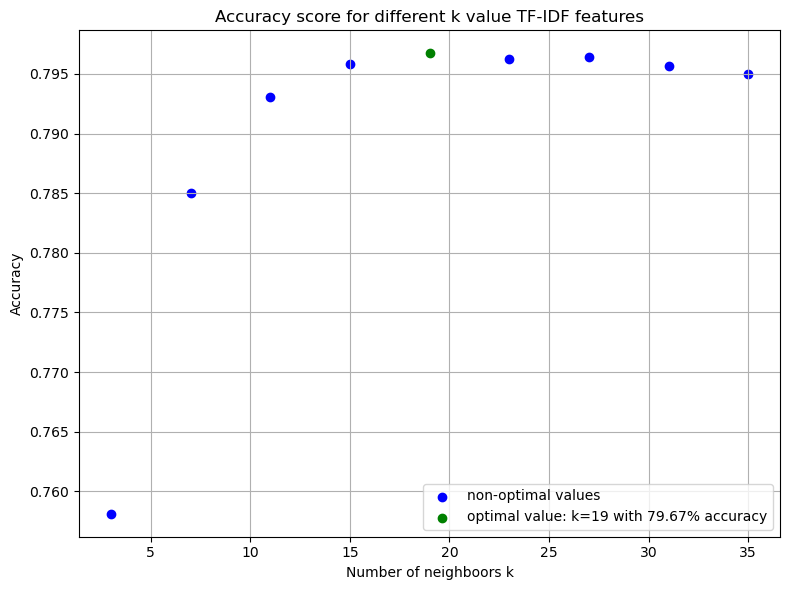

In [76]:
# trying to understand which hyperparameter is the best

scores_tf_idf = {}
for n_n in tqdm(range(3, 36, 4)):
    # instantiate the model: the k-NN classifier
    model_knn = KNeighborsClassifier(n_neighbors=n_n)

    # fit the model to our data
    model_knn.fit(X_train2_TFIDF.values, y_train2_TFIDF)

    # predict on new data
    y_model = model_knn.predict(X_val_TFIDF.values)

    scores_tf_idf[n_n] = accuracy_score(y_val_TFIDF, y_model)

# plot the scores and the accuracy 
keys = list(scores_tf_idf.keys())
values = list(scores_tf_idf.values())

# find maximum value of accuracy and its corresponding k
max_value_TFIDF = max(values)
max_key_TFIDF = keys[values.index(max_value_TFIDF)]

# Plotting the trend of the accuracy for different values of k
plt.figure(figsize=(8,6))
plt.scatter([key for key in keys if key != max_key_TFIDF], [val for val in values if val != max_value_TFIDF], color='blue', label='non-optimal values')
plt.scatter(max_key_TFIDF, max_value_TFIDF, color='green', label=f'optimal value: k={max_key_TFIDF} with {(max_value_TFIDF*100).round(2)}% accuracy')
plt.legend()
plt.xlabel('Number of neighboors k')
plt.ylabel('Accuracy')
plt.title('Accuracy score for different k value TF-IDF features')
plt.grid(True)
plt.tight_layout()
plt.show()

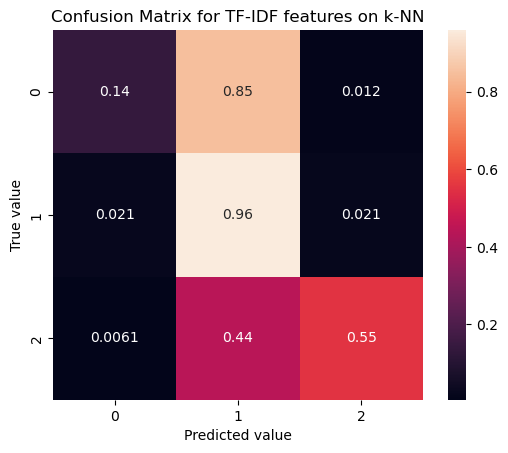

In [77]:
# instantiate the model: the k-NN classifier
model_knn = KNeighborsClassifier(n_neighbors=max_key_TFIDF)

# fit the model to our data
model_knn.fit(X_train2_TFIDF.values, y_train2_TFIDF)

# predict on new data
y_model_TFIDF = model_knn.predict(X_test_TFIDF.values)

# evaluating the model
mat = confusion_matrix(y_test_TFIDF, y_model_TFIDF)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for TF-IDF features on k-NN')
plt.xlabel('Predicted value')
plt.ylabel('True value')

In [ ]:
print("Accuracy: ", accuracy_score(y_test_TFIDF, y_model_TFIDF))

# display classification report
print("Classification Report for TF-IDF features on k-NN:")
print(classification_report(y_test_TFIDF, y_model_TFIDF))

Accuracy:  0.7978456577238321
Classification Report for TF-IDF features on k-NN:
              precision    recall  f1-score   support

           0       0.53      0.14      0.22     17959
           1       0.81      0.96      0.88     99316
           2       0.80      0.55      0.65     16687

    accuracy                           0.80    133962
   macro avg       0.71      0.55      0.58    133962
weighted avg       0.77      0.80      0.76    133962



---

**Comment:**

An accuracy of $ 79.67\% $ in classifying the password strenght via the TF-IDF features is only slightly better than the baseline and from the confusion matrix it's evident that the unbalnceness of the dataset towards the class #1 (*medium*), leads to errors during the prediction:
- The class that obtained the higher True Positive percentage is the class #1, the most popular one;
- Much more than half of the class #0 (*weak*), was wrongly predicted as class #1;
- Almost half of the class #2 (*strong*) was wrongly predicted as class #1.

This can be explained by the imbalance of the dataset, but we noticed this behavior only on this specific application of the k-NN on the TF-IDF features; probably because the TF-IDF approach on characters might capture some patterns, but password strength is a concept too complex for the k-NN algorithm. 

---

**What happens to the performances if we balance the dataset?**

In [50]:
min_num_samples = min(tfidf_features[tfidf_features["Strength"] == 0].shape[0], tfidf_features[tfidf_features["Strength"] == 1].shape[0], tfidf_features[tfidf_features["Strength"] == 2].shape[0])

# sample the rows from each group to match the size of the smallest class
balanced_tfidf_features = tfidf_features.groupby('Strength').apply(lambda x: x.sample(min_num_samples)).reset_index(drop=True)
balanced_tfidf_features

,Password,Strength,,!,"""",#,$,%,&,(,...,ÿ,œ,ƒ,—,‚,‡,…,‹,›,™
0,river45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,preko0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4zvuh8e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,web440,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mh2008,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250003,jose_alda_1305,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250004,9925633398@mike,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250005,730NiRaZetoGaK,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250006,107FIMAJyMoBuSa,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X, y = balanced_tfidf_features.drop(["Password", "Strength"], axis=1), balanced_tfidf_features["Strength"]

# split the data into training and testing sets
X_train_balanced_TFIDF, X_test_balanced_TFIDF, y_train_balanced_TFIDF, y_test_balanced_TFIDF = train_test_split(X, y, test_size=0.2, random_state=42)

# validation set
X_train2_balanced_TFIDF, X_val_balanced_TFIDF, y_train2_balanced_TFIDF, y_val_balanced_TFIDF = train_test_split(X_train_balanced_TFIDF, y_train_balanced_TFIDF, test_size=0.2, random_state=42)

  0%|          | 0/9 [00:00<?, ?it/s]

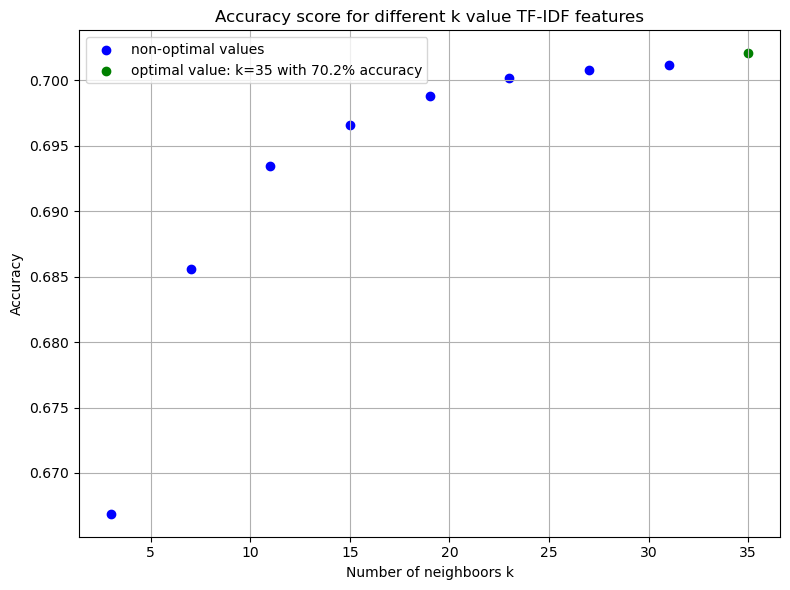

In [58]:
# trying to understand which hyperparameter is the best

scores_tf_idf = {}
for n_n in tqdm(range(3, 36, 4)):
    # instantiate the model: the k-NN classifier
    model_knn = KNeighborsClassifier(n_neighbors=n_n)

    # fit the model to our data
    model_knn.fit(X_train2_balanced_TFIDF.values, y_train2_balanced_TFIDF)

    # predict on new data
    y_model = model_knn.predict(X_val_balanced_TFIDF.values)

    scores_tf_idf[n_n] = accuracy_score(y_val_balanced_TFIDF, y_model)

# plot the scores and the accuracy 
keys = list(scores_tf_idf.keys())
values = list(scores_tf_idf.values())

# find maximum value of accuracy and its corresponding k
max_value_balanced_TFIDF = max(values)
max_key_balanced_TFIDF = keys[values.index(max_value_balanced_TFIDF)]

# Plotting the trend of the accuracy for different values of k
plt.figure(figsize=(8,6))
plt.scatter([key for key in keys if key != max_key_balanced_TFIDF], [val for val in values if val != max_value_balanced_TFIDF], color='blue', label='non-optimal values')
plt.scatter(max_key_balanced_TFIDF, max_value_balanced_TFIDF, color='green', label=f'optimal value: k={max_key_balanced_TFIDF} with {(max_value_balanced_TFIDF*100).round(2)}% accuracy')
plt.legend()
plt.xlabel('Number of neighboors k')
plt.ylabel('Accuracy')
plt.title('Accuracy score for different k value TF-IDF features')
plt.grid(True)
plt.tight_layout()
plt.show()

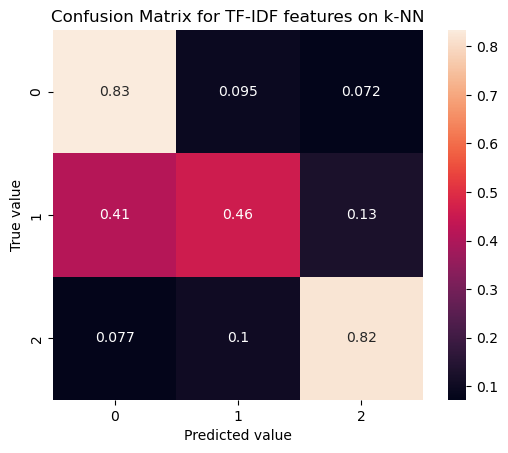

In [60]:
# instantiate the model: the k-NN classifier
model_knn = KNeighborsClassifier(n_neighbors=max_key_balanced_TFIDF)

# fit the model to our data
model_knn.fit(X_train2_balanced_TFIDF.values, y_train2_balanced_TFIDF)

# predict on new data
y_model_balanced_TFIDF = model_knn.predict(X_test_balanced_TFIDF.values)

# evaluating the model
mat = confusion_matrix(y_test_balanced_TFIDF, y_model_balanced_TFIDF)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for TF-IDF features on k-NN')
plt.xlabel('Predicted value')
plt.ylabel('True value');

In [61]:
print("Accuracy: ", accuracy_score(y_test_balanced_TFIDF, y_model_balanced_TFIDF))

# display classification report
print("Classification Report for TF-IDF features on k-NN:")
print(classification_report(y_test_balanced_TFIDF, y_model_balanced_TFIDF))

Accuracy:  0.7053917843286268
Classification Report for TF-IDF features on k-NN:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72     16627
           1       0.70      0.46      0.55     16480
           2       0.81      0.82      0.81     16895

    accuracy                           0.71     50002
   macro avg       0.71      0.70      0.69     50002
weighted avg       0.71      0.71      0.70     50002



---

Accuracy over class "0" and "2" greatly increased but overall accuracy decreased to 70%. Given that in this case the baseline is 33% this result is still significative.

---

**STATISTICAL WITH LENGTH**

  0%|          | 0/9 [00:00<?, ?it/s]

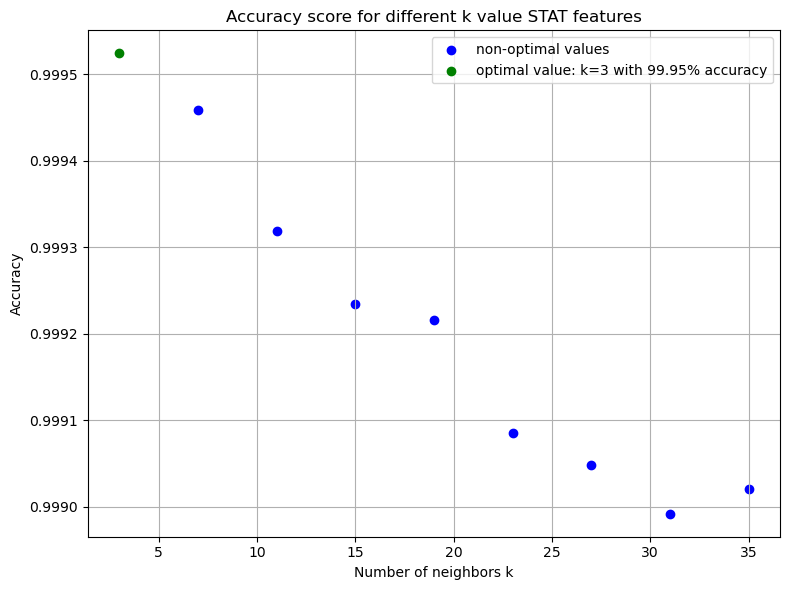

In [62]:
# trying to understand which hyperparameter is the best
scores_stat = {}
for n_n in tqdm(range(3, 36, 4)):
    # instantiate the model: the k-NN classifier
    model_knn = KNeighborsClassifier(n_neighbors=n_n)

    # fit the model to our data
    model_knn.fit(X_train_stat.values, y_train_stat)

    # predict on new data
    y_model = model_knn.predict(X_val_stat.values)

    scores_stat[n_n] = accuracy_score(y_val_stat, y_model)

# plot the scores and the accuracy 
keys = list(scores_stat.keys())
values = list(scores_stat.values())

# find maximum value of accuracy and its corresponding k
max_value_stat = max(values)
max_key_stat = keys[values.index(max_value_stat)]

# plotting the trend of the accuracy for different values of k
plt.figure(figsize=(8,6))
plt.scatter([key for key in keys if key != max_key_stat], [val for val in values if val != max_value_stat], color='blue', label='non-optimal values')
plt.scatter(max_key_stat, max_value_stat, color='green', label=f'optimal value: k={max_key_stat} with {(max_value_stat*100).round(2)}% accuracy')
plt.legend()
plt.xlabel('Number of neighbors k')
plt.ylabel('Accuracy')
plt.title('Accuracy score for different k value STAT features')
plt.grid(True)
plt.tight_layout()
plt.show()

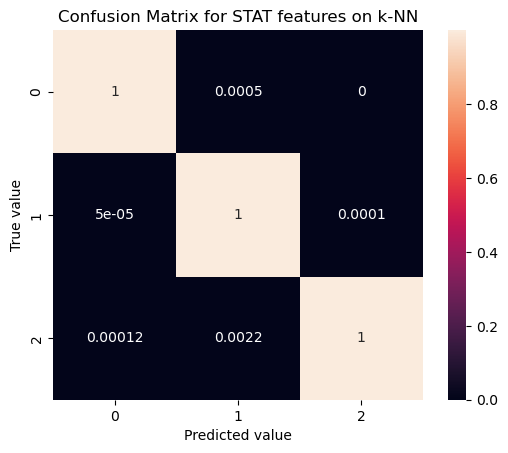

In [65]:
# instantiate the model: the k-NN classifier
model_knn = KNeighborsClassifier(n_neighbors=max_key_stat)

# fit the model to our data
model_knn.fit(X_train_stat.values, y_train_stat)

# predict on new data
y_model_stat = model_knn.predict(X_test_stat.values)

# evaluating the model
mat = confusion_matrix(y_test_stat, y_model_stat)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for STAT features on k-NN')
plt.xlabel('Predicted value')
plt.ylabel('True value');

In [66]:
print("Accuracy: ", accuracy_score(y_test_stat, y_model_stat))

# display classification report
print("Classification Report for STAT features on k-NN:")
print(classification_report(y_test_stat, y_model_stat))

Accuracy:  0.9995371821859931
Classification Report for STAT features on k-NN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      1.00      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



**STATISTICAL W/O LENGTH**

  0%|          | 0/9 [00:00<?, ?it/s]

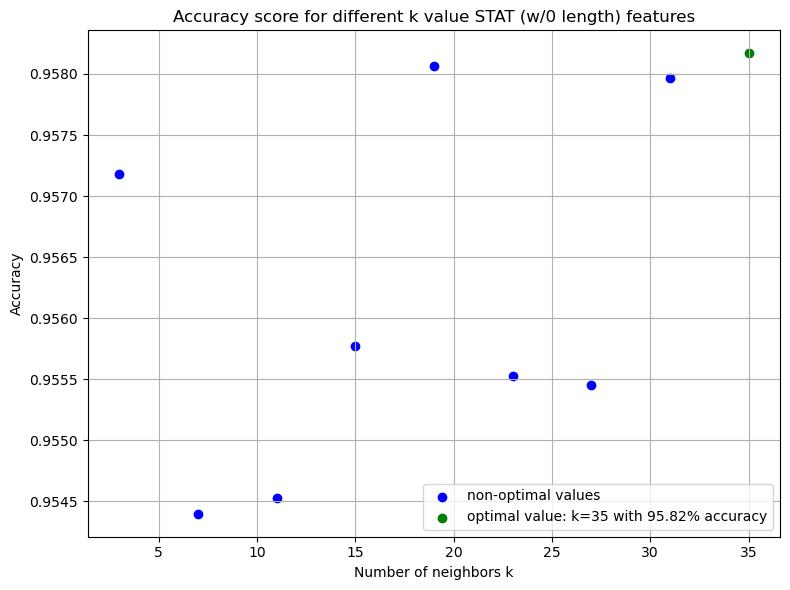

In [68]:
# trying to understand which hyperparameter is the best
scores_stat = {}
for n_n in tqdm(range(3, 36, 4)):
    # instantiate the model: the k-NN classifier
    model_knn = KNeighborsClassifier(n_neighbors=n_n)

    # fit the model to our data
    model_knn.fit(X_train_stat_nolength.values, y_train_stat_nolength)

    # predict on new data
    y_model = model_knn.predict(X_val_stat_nolength.values)

    scores_stat[n_n] = accuracy_score(y_val_stat_nolength, y_model)

# plot the scores and the accuracy 
keys = list(scores_stat.keys())
values = list(scores_stat.values())

# find maximum value of accuracy and its corresponding k
max_value_stat_nolength = max(values)
max_key_stat_nolength = keys[values.index(max_value_stat_nolength)]

# plotting the trend of the accuracy for different values of k
plt.figure(figsize=(8,6))
plt.scatter([key for key in keys if key != max_key_stat_nolength], [val for val in values if val != max_value_stat_nolength], color='blue', label='non-optimal values')
plt.scatter(max_key_stat_nolength, max_value_stat_nolength, color='green', label=f'optimal value: k={max_key_stat_nolength} with {(max_value_stat_nolength*100).round(2)}% accuracy')
plt.legend()
plt.xlabel('Number of neighbors k')
plt.ylabel('Accuracy')
plt.title('Accuracy score for different k value STAT (w/0 length) features')
plt.grid(True)
plt.tight_layout()
plt.show()

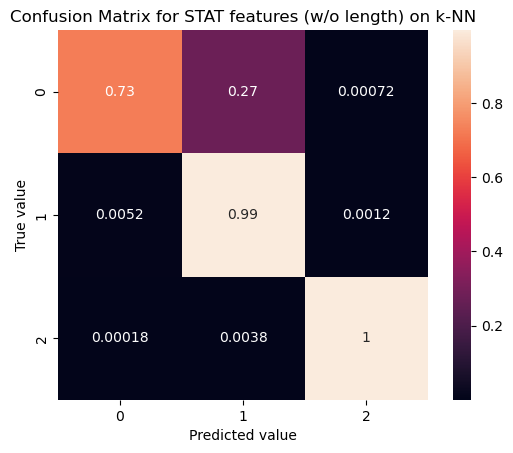

In [69]:
# instantiate the model: the k-NN classifier
model_knn = KNeighborsClassifier(n_neighbors=max_key_stat_nolength)

# fit the model to our data
model_knn.fit(X_train_stat_nolength.values, y_train_stat_nolength)

# predict on new data
y_model_stat_nolength = model_knn.predict(X_test_stat_nolength.values)

# evaluating the model
mat = confusion_matrix(y_test_stat_nolength, y_model_stat_nolength)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for STAT features (w/o length) on k-NN')
plt.xlabel('Predicted value')
plt.ylabel('True value');

In [72]:
print(f'Accuracy score of the STAT features (w/o length) k = 35: {accuracy_score(y_test_stat_nolength, y_model_stat_nolength)}')

# display classification report
print("Classification Report for CHAR features on k-NN:")
print(classification_report(y_test_stat_nolength, y_model_stat_nolength))

Accuracy score of the STAT features (w/o length) k = 3: 0.9581075230289187
Classification Report for CHAR features on k-NN:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     17959
           1       0.95      0.99      0.97     99316
           2       0.99      1.00      0.99     16687

    accuracy                           0.96    133962
   macro avg       0.97      0.91      0.93    133962
weighted avg       0.96      0.96      0.96    133962



**PER-CHARACTER**

---

Since the execution of the hyperparameter tuning on this features is too slow we'll just apply two values of k, the best ones for the previous prediction on other features, and see which is best.

---

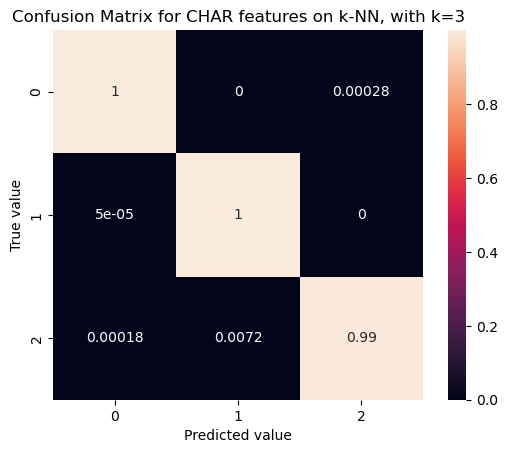

In [76]:
# instantiate the model: the k-NN classifier with k=3
model_knn = KNeighborsClassifier(n_neighbors=max_key_stat) # n_neighbors = 3

# fit the model to our data
model_knn.fit(X_train_CHAR.values, y_train_CHAR)

# predict on new data
y_model_char = model_knn.predict(X_test_CHAR.values)

# evaluating the model
mat = confusion_matrix(y_test_CHAR, y_model_char)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for CHAR features on k-NN, with k=3')
plt.xlabel('Predicted value')
plt.ylabel('True value');

In [77]:
print(f'Accuracy score of the CHAR features with k = 3: {accuracy_score(y_val_CHAR, y_model)}')

# display classification report
print("Classification Report for CHAR features on k-NN:")
print(classification_report(y_test_CHAR, y_model_char))

Accuracy score of the CHAR features with k = 3: 0.9989175974395581
Classification Report for CHAR features on k-NN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      0.99      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



Text(77.92222222222227, 0.5, 'True value')

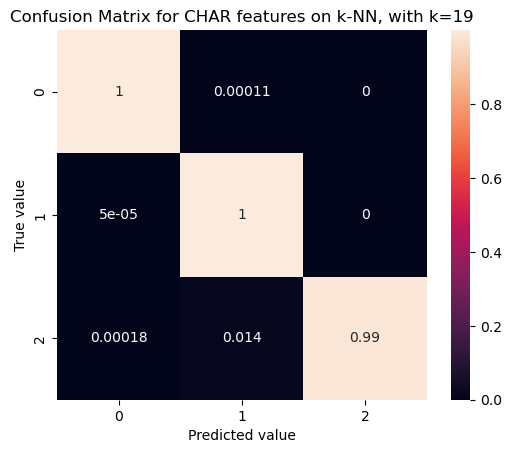

In [23]:
# instantiate the model: the k-NN classifier with k=19
model_knn = KNeighborsClassifier(n_neighbors=max_key_TFIDF) # n_neighbors = 19

# fit the model to our data
model_knn.fit(X_train_CHAR.values, y_train_CHAR)

# predict on new data
y_model_char = model_knn.predict(X_test_CHAR.values)

# evaluating the model
mat = confusion_matrix(y_test_CHAR, y_model_char)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for CHAR features on k-NN, with k=19')
plt.xlabel('Predicted value')
plt.ylabel('True value')

In [26]:
print(f'Accuracy score of the CHAR features with k = 19: {accuracy_score(y_test_CHAR, y_model_char)}')

# display classification report
print("Classification Report for CHAR features on k-NN:")
print(classification_report(y_test_CHAR, y_model_char))

Accuracy score of the CHAR features with k = 19: 0.9981412639405205
Classification Report for CHAR features on k-NN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      0.99      0.99     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



## Logistic regression

---

Models give ConvergenceWarning but we tried increasing the number of iteration and observed no meaninful increase in performance, therefore we ignore the warning and keep the number of iteration low to reduce the execution time.

---

In [43]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

**STATISTICAL WITH LENGTH**

In [44]:
model_stat = LogisticRegression(max_iter=10000)
model_stat.fit(X_train_stat, y_train_stat)
y_pred_stat = model_stat.predict(X_test_stat)

accuracy_stat = accuracy_score(y_test_stat, y_pred_stat)
print(f'Accuracy: {accuracy_stat}')

report_stat = classification_report(y_test_stat, y_pred_stat)
print('Classification Report:\n', report_stat)

Accuracy: 0.9995969006136068
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      1.00      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



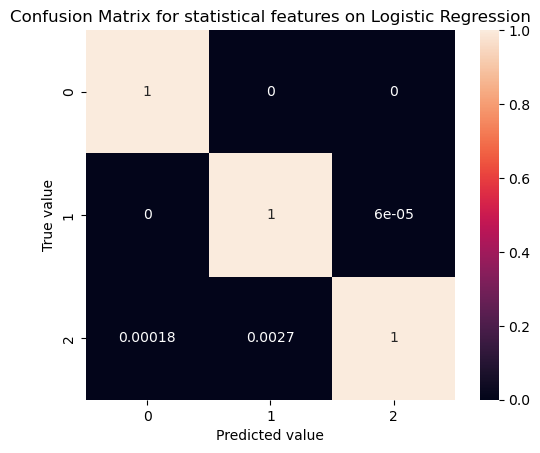

In [45]:
mat_logistic_stat = confusion_matrix(y_test_stat, y_pred_stat)
normalized_mat_logistic_stat = mat_logistic_stat.astype('float') / mat_logistic_stat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat_logistic_stat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for statistical features on Logistic Regression')
plt.xlabel('Predicted value')
plt.ylabel('True value');

**STATISTICAL W/O LENGTH**

In [46]:
model_stat = LogisticRegression(max_iter=10000)
model_stat.fit(X_train_stat_nolength, y_train_stat_nolength)
y_pred_stat_nolength = model_stat.predict(X_test_stat_nolength)

accuracy_stat = accuracy_score(y_test_stat_nolength, y_pred_stat_nolength)
print(f'Accuracy: {accuracy_stat}')

report_stat = classification_report(y_test_stat_nolength, y_pred_stat_nolength)
print('Classification Report:\n', report_stat)

Accuracy: 0.8352816470342336
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.00      0.00     17959
           1       0.83      0.99      0.90     99316
           2       0.89      0.84      0.86     16687

    accuracy                           0.84    133962
   macro avg       0.61      0.61      0.59    133962
weighted avg       0.74      0.84      0.78    133962



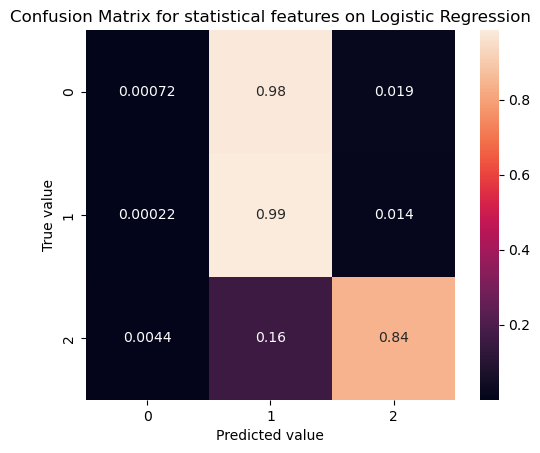

In [47]:
mat_logistic_stat = confusion_matrix(y_test_stat_nolength, y_pred_stat_nolength)
normalized_mat_logistic_stat = mat_logistic_stat.astype('float') / mat_logistic_stat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat_logistic_stat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for statistical features on Logistic Regression')
plt.xlabel('Predicted value')
plt.ylabel('True value');

**TF-IDF**

In [48]:
model_TFIDF = LogisticRegression(max_iter=10000)
model_TFIDF.fit(X_train2_TFIDF, y_train2_TFIDF)
y_pred_TFIDF = model_TFIDF.predict(X_test_TFIDF)

accuracy_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)
print(f'Accuracy: {accuracy_TFIDF}')

report_TFIDF = classification_report(y_test_TFIDF, y_pred_TFIDF)
print('Classification Report:\n', report_TFIDF)

Accuracy: 0.8189859810991177
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.30      0.39     17959
           1       0.84      0.94      0.88     99316
           2       0.82      0.69      0.75     16687

    accuracy                           0.82    133962
   macro avg       0.74      0.64      0.67    133962
weighted avg       0.80      0.82      0.80    133962



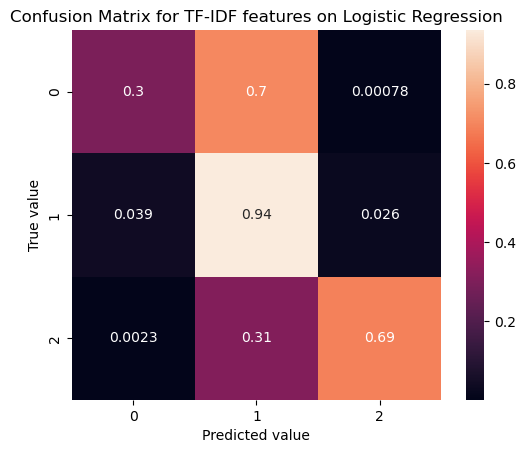

In [49]:
mat_logistic_TFIDF = confusion_matrix(y_test_TFIDF, y_pred_TFIDF)
normalized_mat_logistic_TFIDF = mat_logistic_TFIDF.astype('float') / mat_logistic_TFIDF.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat_logistic_TFIDF, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for TF-IDF features on Logistic Regression')
plt.xlabel('Predicted value')
plt.ylabel('True value');

**PER-CHARACTER**

In [50]:
model_CHAR = LogisticRegression(max_iter=10000)
model_CHAR.fit(X_train_CHAR, y_train_CHAR)
y_pred_CHAR = model_CHAR.predict(X_test_CHAR)

accuracy_CHAR = accuracy_score(y_test_CHAR, y_pred_CHAR)
print(f'Accuracy: {accuracy_CHAR}')

report_CHAR = classification_report(y_test_CHAR, y_pred_CHAR)
print('Classification Report:\n', report_CHAR)

Accuracy: 0.999701407861931
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      1.00      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



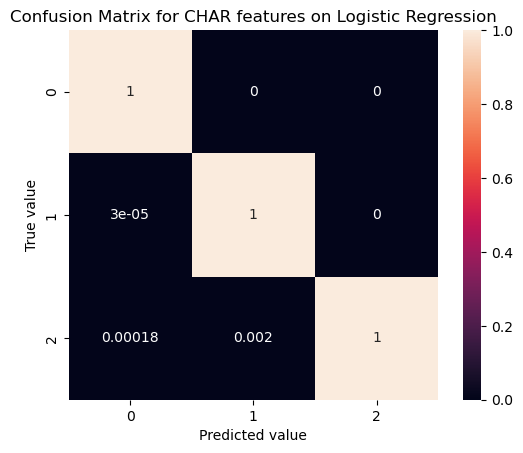

In [51]:
mat_logistic_CHAR = confusion_matrix(y_test_CHAR, y_pred_CHAR)
normalized_mat_logistic_CHAR = mat_logistic_CHAR.astype('float') / mat_logistic_CHAR.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat_logistic_CHAR, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for CHAR features on Logistic Regression')
plt.xlabel('Predicted value')
plt.ylabel('True value');

---

We can observe very high results on the datasets that contains information about length but mediocre results on the other two.

---

## Neural networks

---

We use Grid Search to find the best hyperparameters for the network.

---

**STATISTICAL WITH LENGTH**

In [58]:
split_index = [-1]*len(X_train_stat) + [0]*len(X_val_stat)
X_concatenated = np.concatenate((X_train_stat, X_val_stat), axis=0)
y_concatenated = np.concatenate((y_train_stat, y_val_stat), axis=0)

pds = PredefinedSplit(test_fold = split_index)
param_grid = {'learning_rate_init': [0.001, 0.01, 0.1],
              'activation': ['tanh', 'relu'],
              'hidden_layer_sizes': [(64,),(64, 64)],
              }

mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter = 1000, random_state=42, 
                    early_stopping = True, validation_fraction = 0.1, n_iter_no_change=10)

grid_search = GridSearchCV(mlp, param_grid, cv=pds, scoring='accuracy', verbose=1)
grid_search.fit(X_concatenated, y_concatenated)

model_stat = grid_search.best_estimator_
y_pred_stat = model_stat.predict(X_test_stat.values)

print('The best parameters we found are:\n', grid_search.best_params_)

accuracy_stat = accuracy_score(y_test_stat, y_pred_stat)
print(f'Accuracy: {accuracy_stat}')

report_stat = classification_report(y_test_stat, y_pred_stat)
print('Classification Report:\n', report_stat)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
The best parameters we found are:
 {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}
Accuracy: 0.9996864782550275
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      1.00      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



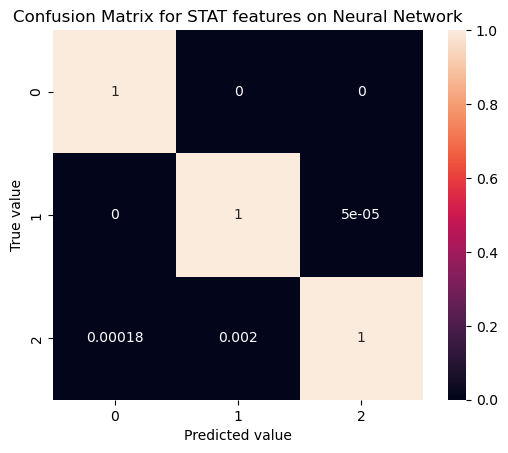

In [61]:
# evaluating the model
mat = confusion_matrix(y_test_stat, y_pred_stat)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for STAT features on Neural Network')
plt.xlabel('Predicted value')
plt.ylabel('True value');

**STATISTICAL W/O LENGTH**

In [60]:
split_index = [-1]*len(X_train_stat_nolength) + [0]*len(X_val_stat_nolength)
X_concatenated = np.concatenate((X_train_stat_nolength, X_val_stat_nolength), axis=0)
y_concatenated = np.concatenate((y_train_stat_nolength, y_val_stat_nolength), axis=0)

pds = PredefinedSplit(test_fold = split_index)
param_grid = {'learning_rate_init': [0.001, 0.01, 0.1],
              'activation': ['tanh', 'relu'],
              'hidden_layer_sizes': [(64,),(64, 64)],
              }

mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter = 1000, random_state=42, 
                    early_stopping = True, validation_fraction = 0.1, n_iter_no_change=10)

grid_search = GridSearchCV(mlp, param_grid, cv=pds, scoring='accuracy', verbose=1)
grid_search.fit(X_concatenated, y_concatenated)

model_stat_nolength = grid_search.best_estimator_
y_pred_stat_nolength = model_stat_nolength.predict(X_test_stat_nolength.values)

print('The best parameters we found are:\n', grid_search.best_params_)

accuracy_stat_nolength = accuracy_score(y_test_stat_nolength, y_pred_stat_nolength)
print(f'Accuracy: {accuracy_stat_nolength}')

report_stat_nolength = classification_report(y_test_stat_nolength, y_pred_stat_nolength)
print('Classification Report:\n', report_stat_nolength)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
The best parameters we found are:
 {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}
Accuracy: 0.956659351159284
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82     17959
           1       0.95      0.99      0.97     99316
           2       0.99      1.00      1.00     16687

    accuracy                           0.96    133962
   macro avg       0.97      0.90      0.93    133962
weighted avg       0.96      0.96      0.95    133962



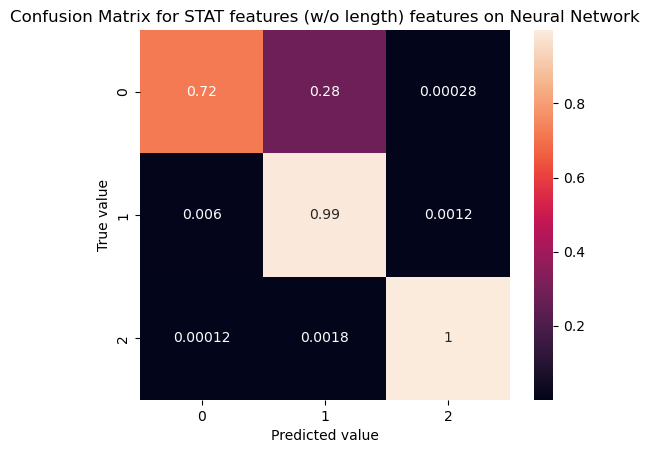

In [62]:
# evaluating the model
mat = confusion_matrix(y_test_stat_nolength, y_pred_stat_nolength)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for STAT features (w/o length) features on Neural Network')
plt.xlabel('Predicted value')
plt.ylabel('True value');

---

The training for the data without information regarding the length of the password is much slower. We can explain it by the fact that the network has to find more complex relations between data instead of relying on the only on the password length.

---

**TF-IDF**

In [63]:
split_index = [-1]*len(X_train2_TFIDF) + [0]*len(X_val_TFIDF)
X_concatenated = np.concatenate((X_train2_TFIDF, X_val_TFIDF), axis=0)
y_concatenated = np.concatenate((y_train2_TFIDF, y_val_TFIDF), axis=0)

pds = PredefinedSplit(test_fold = split_index)
param_grid = {'learning_rate_init': [0.001, 0.01, 0.1],
              'activation': ['tanh', 'relu'],
              'hidden_layer_sizes': [(64,),(64, 64)],
              }

mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter = 1000, random_state=42, 
                    early_stopping = True, validation_fraction = 0.1, n_iter_no_change=10)

grid_search = GridSearchCV(mlp, param_grid, cv=pds, scoring='accuracy', verbose=1)
grid_search.fit(X_concatenated, y_concatenated)

model_TFIDF = grid_search.best_estimator_
y_pred_TFIDF = model_TFIDF.predict(X_test_TFIDF.values)

print('The best parameters we found are:\n', grid_search.best_params_)

accuracy_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)
print(f'Accuracy: {accuracy_TFIDF}')

report_stat_TFIDF = classification_report(y_test_TFIDF, y_pred_TFIDF)
print('Classification Report:\n', report_stat_TFIDF)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
The best parameters we found are:
 {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}
Accuracy: 0.9857944790313671
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17959
           1       0.99      0.99      0.99     99316
           2       1.00      0.96      0.98     16687

    accuracy                           0.99    133962
   macro avg       0.98      0.98      0.98    133962
weighted avg       0.99      0.99      0.99    133962



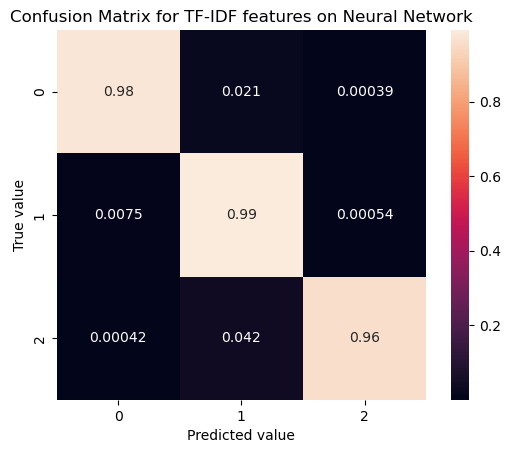

In [64]:
# evaluating the model
mat = confusion_matrix(y_test_TFIDF, y_pred_TFIDF)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for TF-IDF features on Neural Network')
plt.xlabel('Predicted value')
plt.ylabel('True value');

---

Also TF-IDF is very slow even if compared with the previous one, probably due to the high number of columns. The results however are surprising, the accuracy we got is very high given that this dataset does not contain information about length.

---

**PER-CHARACTER**

In [65]:
split_index = [-1]*len(X_train_CHAR) + [0]*len(X_val_CHAR)
X_concatenated = np.concatenate((X_train_CHAR, X_val_CHAR), axis=0)
y_concatenated = np.concatenate((y_train_CHAR, y_val_CHAR), axis=0)

pds = PredefinedSplit(test_fold = split_index)
param_grid = {'learning_rate_init': [0.001, 0.01, 0.1],
              'activation': ['tanh', 'relu'],
              'hidden_layer_sizes': [(64,),(64, 64)],
              }

mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter = 1000, random_state=42, 
                    early_stopping = True, validation_fraction = 0.1, n_iter_no_change=10)

grid_search = GridSearchCV(mlp, param_grid, cv=pds, scoring='accuracy', verbose=1)
grid_search.fit(X_concatenated, y_concatenated)

model_CHAR = grid_search.best_estimator_
y_pred_CHAR = model_CHAR.predict(X_test_CHAR.values)

print('The best parameters we found are:\n', grid_search.best_params_)

accuracy_CHAR = accuracy_score(y_test_CHAR, y_pred_CHAR)
print(f'Accuracy: {accuracy_CHAR}')

report_stat_CHAR = classification_report(y_test_CHAR, y_pred_CHAR)
print('Classification Report:\n', report_stat_CHAR)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
The best parameters we found are:
 {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}
Accuracy: 0.9996864782550275
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17959
           1       1.00      1.00      1.00     99316
           2       1.00      1.00      1.00     16687

    accuracy                           1.00    133962
   macro avg       1.00      1.00      1.00    133962
weighted avg       1.00      1.00      1.00    133962



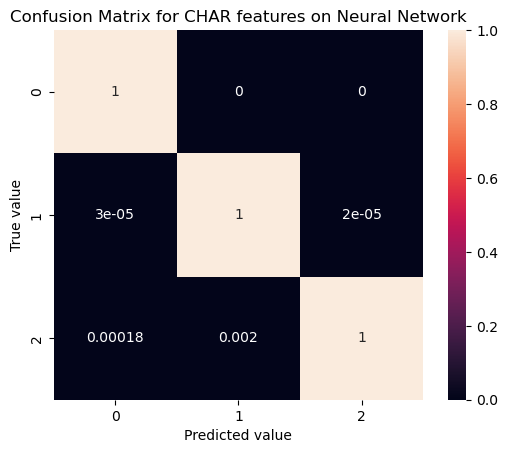

In [66]:
# evaluating the model
mat = confusion_matrix(y_test_CHAR, y_pred_CHAR)

# normalized confusion matrix
normalized_mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(normalized_mat, square=True, annot=True, cbar=True)
plt.title('Confusion Matrix for CHAR features on Neural Network')
plt.xlabel('Predicted value')
plt.ylabel('True value');

---

We notice that also the CHAR dataset had a very fast execution and we can attribuite it to the fact that it also contains implicitly informations about the password length.

---

---

**Comments:**

As the problem revealed itself much easier than what we predicted approaches based on neural networks may not be necessary to obtain good results. Every type of feature extraction got really good results.

Stat features got really good results, as they did with other models because length seems to be enough to discriminate in almost all cases. So we tried removing from the dataset all the features that could contain informations about the password length, as "length", "entropy", "lowercase_count" ecc., this made our dataset composed only of frequencies and booleans. With this approach we obtained interesting results: easily discriminates between class "2" and "1" but there is a considerable amount of elements in class "0" that are being incorrectly classified as class "1".

This results become even more interesting when we analyze the results obtained with TF-IDF features: even if they intrinsically do not contain informations about length the performances are very high, about only 1% lower than what with approaches that mantain informations about length. This is considerable given that using the same kind of features yields much worse results when using approaches different from Neural Networks.

Finally using the third type of features yields optimal results, with a minimal increase from what we get from stat features as we can imagine the neural network managed to get more useful features than what a human could do.

---

## Decision tree

**TF-IDF**

In [67]:
# create a decision tree classifier object
clf = DecisionTreeClassifier(random_state=42)

# train the model using the training sets
clf.fit(X_train_TFIDF, y_train_TFIDF)

y_test_pred_TFIDF = clf.predict(X_test_TFIDF)

In [68]:
# calculate metrics for test set
precision_test = precision_score(y_test_TFIDF, y_test_pred_TFIDF, average='weighted')
recall_test = recall_score(y_test_TFIDF, y_test_pred_TFIDF, average='weighted')
accuracy_test = accuracy_score(y_test_TFIDF, y_test_pred_TFIDF)

table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Test Set': [precision_test, recall_test, accuracy_test]
})

print(table)

      Metric  Test Set
0  Precision  0.925911
1     Recall  0.926098
2   Accuracy  0.926098


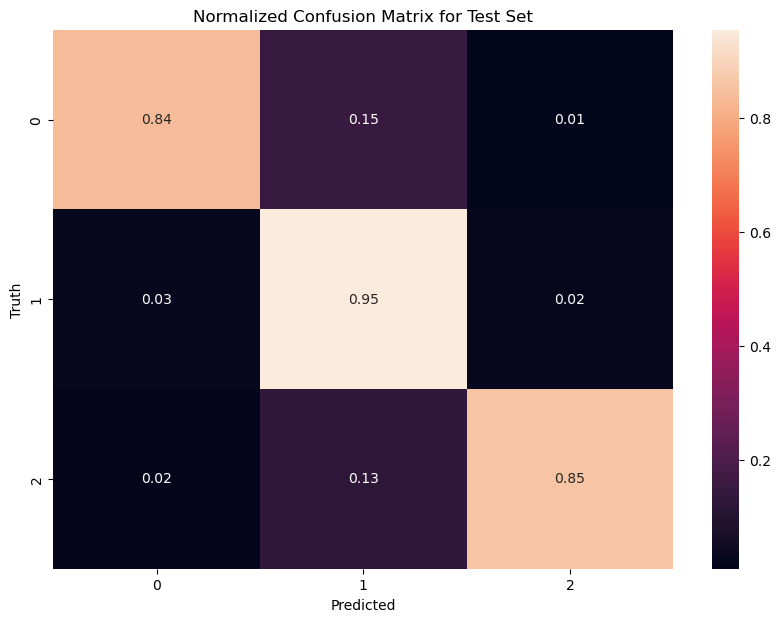

In [69]:
# calculate confusion matrix for test set
cm_test_TFIDF = confusion_matrix(y_test_TFIDF, y_test_pred_TFIDF)

# normalize the confusion matrix
cm_test_TFIDF_normalized = cm_test_TFIDF.astype('float') / cm_test_TFIDF.sum(axis=1)[:, np.newaxis]

# plot normalized confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(cm_test_TFIDF_normalized, annot=True, fmt='.2f')
plt.title('Normalized Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [70]:
importances = clf.feature_importances_
feature_names = X_train_TFIDF.columns
feature_imp_df = pd.DataFrame({'Feature Name':feature_names, 'Importance':importances})
print(feature_imp_df.sort_values(by='Importance', ascending=False))

   Feature Name  Importance
52            q    0.143970
15            1    0.139861
49            n    0.067435
53            r    0.063961
36            a    0.048580
..          ...         ...
82            ¿    0.000000
95            ï    0.000000
83            ×    0.000000
93            í    0.000000
80            ½    0.000000

[120 rows x 2 columns]


**STATISTICAL WITH LENGTH**


In [71]:
# create a decision tree classifier object
clf = DecisionTreeClassifier(random_state=42)

# train the model using the training sets
clf.fit(X_train_stat, y_train_stat)

y_test_pred_stat = clf.predict(X_test_stat)

In [72]:
# calculate metrics for the test set
precision_test = precision_score(y_test_stat, y_test_pred_stat, average='weighted')
recall_test = recall_score(y_test_stat, y_test_pred_stat, average='weighted')
accuracy_test = accuracy_score(y_test_stat, y_test_pred_stat)

# create a DataFrame for the table
table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Test Set': [precision_test, recall_test, accuracy_test]
})

print(table)

      Metric  Test Set
0  Precision  0.999709
1     Recall  0.999709
2   Accuracy  0.999709


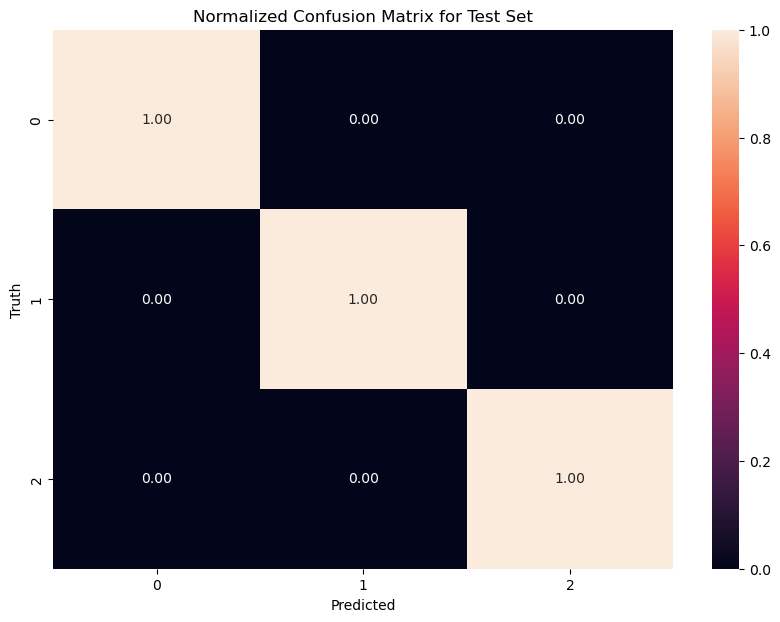

In [73]:
# calculate confusion matrix for test set
cm_test_stat = confusion_matrix(y_test_stat, y_test_pred_stat)

# normalize the confusion matrix
cm_test_stat_normalized = cm_test_stat.astype('float') / cm_test_stat.sum(axis=1)[:, np.newaxis]

# plot normalized confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(cm_test_stat_normalized, annot=True, fmt='.2f')
plt.title('Normalized Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [74]:
importances = clf.feature_importances_
feature_names = X_train_stat.columns
feature_imp_df = pd.DataFrame({'Feature Name':feature_names, 'Importance':importances})
print(feature_imp_df.sort_values(by='Importance', ascending=False))

                     Feature Name    Importance
0                          length  9.997548e-01
1                     num_letters  9.003557e-05
14                        entropy  2.703470e-05
12              numbers_frequency  2.074801e-05
4              percentage_numbers  2.010549e-05
11            uppercase_frequency  1.458452e-05
3                     num_numbers  1.032266e-05
5          has_special_characters  9.573781e-06
2              percentage_letters  9.362521e-06
8                 lowercase_count  8.050077e-06
13           unique_char_presence  7.538720e-06
9            percentage_lowercase  7.208679e-06
19                    common_word  6.488535e-06
10            lowercase_frequency  6.275367e-06
7            percentage_uppercase  4.615480e-06
16  consecutive_lowercase_letters  2.814155e-06
17            consecutive_numbers  1.634144e-07
6                 uppercase_count  1.417109e-07
20                     year_birth  1.114435e-07
15  consecutive_uppercase_letters  6.362

**STATISTICAL W/O LENGTH**

In [75]:
# create a decision tree classifier object
clf = DecisionTreeClassifier(random_state=42)

# train the model using the training sets
clf.fit(X_train_stat_nolength, y_train_stat_nolength)

y_test_pred_stat_nolength = clf.predict(X_test_stat_nolength)

In [76]:
precision_test = precision_score(y_test_stat_nolength, y_test_pred_stat_nolength, average='weighted')
recall_test = recall_score(y_test_stat_nolength, y_test_pred_stat_nolength, average='weighted')
accuracy_test = accuracy_score(y_test_stat_nolength, y_test_pred_stat_nolength)

table = pd.DataFrame({  # Creates a DataFrame for the table
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Test Set': [precision_test, recall_test, accuracy_test]
})

print(table)  # Prints the table

      Metric  Test Set
0  Precision  0.958928
1     Recall  0.958682
2   Accuracy  0.958682


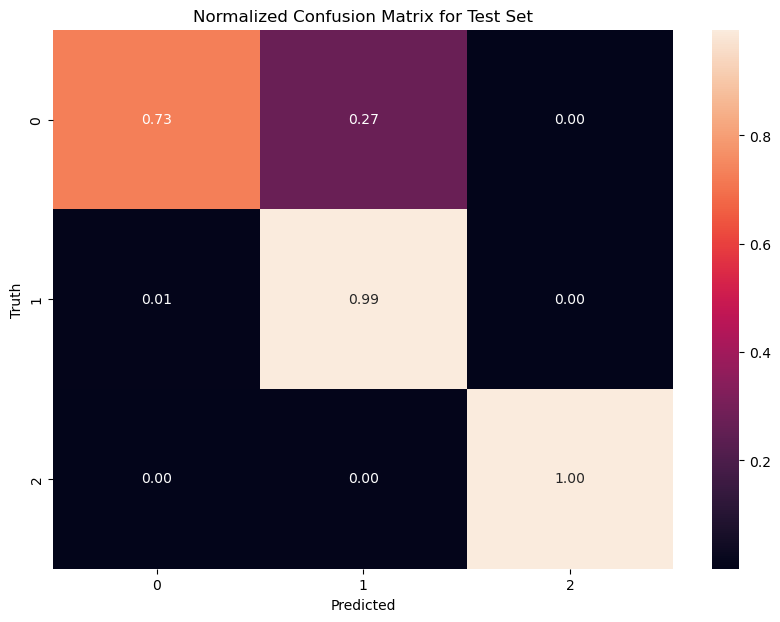

In [77]:
# Calculate confusion matrix for test set
cm_test_stat = confusion_matrix(y_test_stat_nolength, y_test_pred_stat_nolength)

# Normalize the confusion matrix
cm_test_stat_normalized = cm_test_stat.astype('float') / cm_test_stat.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(cm_test_stat_normalized, annot=True, fmt='.2f')
plt.title('Normalized Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [123]:
importances = clf.feature_importances_
feature_names = X_train_stat_nolength.columns
feature_imp_df = pd.DataFrame({'Feature Name':feature_names, 'Importance':importances})
print(feature_imp_df.sort_values(by='Importance', ascending=False))

                     Feature Name  Importance
3            percentage_uppercase    0.414598
5             lowercase_frequency    0.174722
7               numbers_frequency    0.137239
0              percentage_letters    0.080568
4            percentage_lowercase    0.072471
11            consecutive_numbers    0.044810
2          has_special_characters    0.033273
1              percentage_numbers    0.021037
8            unique_char_presence    0.010980
10  consecutive_lowercase_letters    0.003969
13                    common_word    0.003114
6             uppercase_frequency    0.002571
14                     year_birth    0.000323
9   consecutive_uppercase_letters    0.000271
12                querty_sequence    0.000052


**PER-CHARACTER**

In [78]:
# create a decision tree classifier object
clf = DecisionTreeClassifier(random_state=42)

# train the model using the training sets
clf.fit(X_train_CHAR, y_train_CHAR)

y_test_pred_CHAR = clf.predict(X_test_CHAR)

In [79]:
# calculate metrics for the test set
precision_test = precision_score(y_test_CHAR, y_test_pred_CHAR, average='weighted')
recall_test = recall_score(y_test_CHAR, y_test_pred_CHAR, average='weighted')
accuracy_test = accuracy_score(y_test_CHAR, y_test_pred_CHAR)

# create a DataFrame for the table
table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Test Set': [precision_test, recall_test, accuracy_test]
})

print(table)

      Metric  Test Set
0  Precision  0.999709
1     Recall  0.999709
2   Accuracy  0.999709


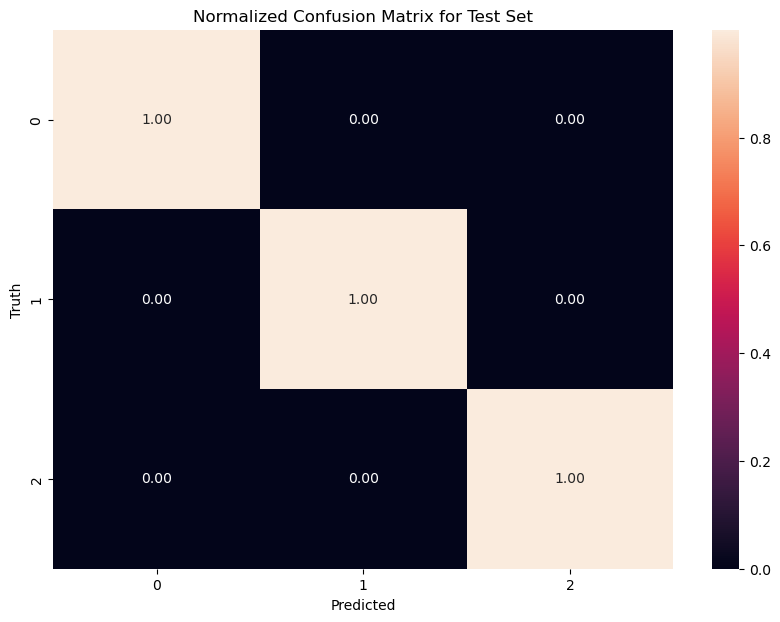

In [80]:
# calculate confusion matrix for test set
cm_test_CHAR = confusion_matrix(y_test_CHAR, y_test_pred_CHAR)

# normalize the confusion matrix
cm_test_CHAR_normalized = cm_test_CHAR.astype('float') / cm_test_CHAR.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(cm_test_CHAR_normalized, annot=True, fmt='.2f')
plt.title('Normalized Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [81]:
importances = clf.feature_importances_
feature_names = X_train_CHAR.columns
feature_imp_df = pd.DataFrame({'Feature Name':feature_names, 'Importance':importances})
print(feature_imp_df.sort_values(by='Importance', ascending=False))

     Feature Name  Importance
20       13=empty    0.510274
135       7=empty    0.488648
140       8=empty    0.000565
25       14=empty    0.000273
4     0=uppercase    0.000039
..            ...         ...
52      19=number    0.000000
51   19=lowercase    0.000000
50       19=empty    0.000000
49   18=uppercase    0.000000
75       23=empty    0.000000

[150 rows x 2 columns]


---

**Comment:**

For the TF-IDF dataset we have accuracy, precision and recall values equal to $0.92$, in fact, as it's clearly shown in the confusion matrix, there are $94736$ well-predicted values; the most important features are the `q` and `1`, probably due to the fact that the most frequent number is `1` and makes the password stronger, and the presence of the `q` usually implies the absence of real words.

With the statistical dataset, the metrics are all equal to $0.99$, because in this datset are both present the lenght and the entropy of the passwords, which heavly influence our model.

Also for the per-char dataset we have good metrics, all equal to $0,99$.

---